In [1]:
import sys
sys.path.append("..")
import shap
import xgboost
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import train_test_split

In [2]:
shap.initjs()

In [3]:
# train XGBoost model
X,y = shap.datasets.diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [4]:
X_instanced = pd.concat((X,pd.DataFrame(columns = ['instance'])),axis = 1)
X_instanced['instance'].loc[X_train.index] = 'train'
X_instanced['instance'].loc[X_test.index] = 'test'
y_instanced = pd.concat((pd.DataFrame(y),pd.DataFrame(columns = ['instance'])),axis = 1)
y_instanced['instance'].loc[X_train.index] = 'train'
y_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [6]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [7]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

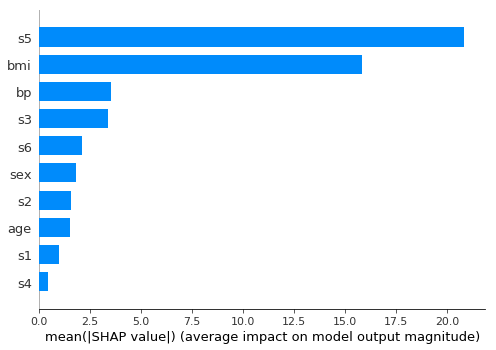

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X,plot_type = 'bar')

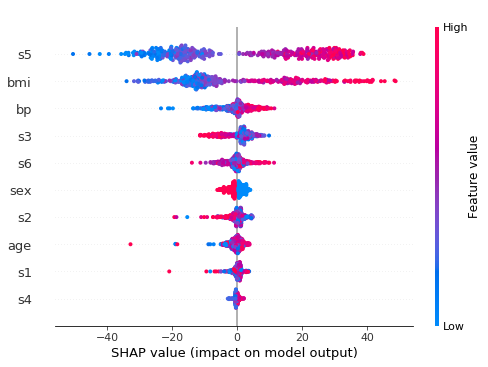

In [9]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [10]:
#Gather shapley values and output values in one dataframe
shap_dataframe = pd.DataFrame(data = shap_values,columns = X.columns)
output_dataframe = pd.DataFrame(data = y,columns = ['diabetes'])
shap_dataframe = pd.concat([shap_dataframe,output_dataframe],axis = 1)

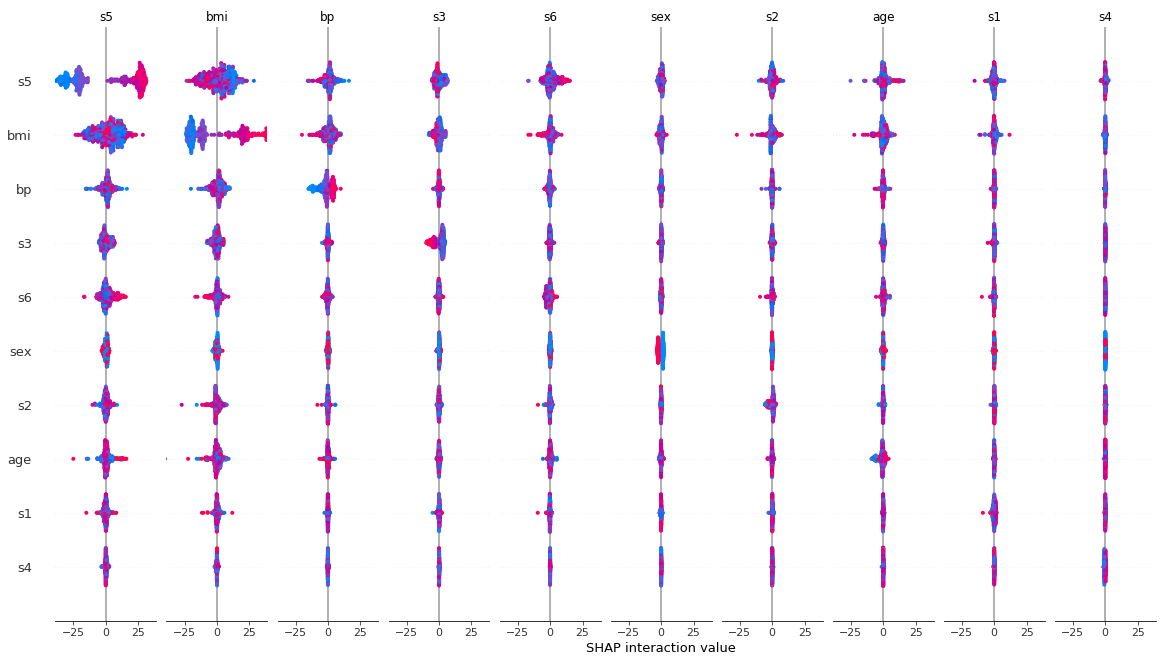

In [11]:
#Make interaction plot for all features
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X, max_display = 10)

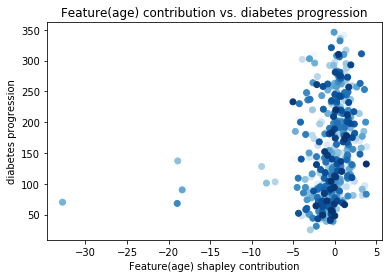

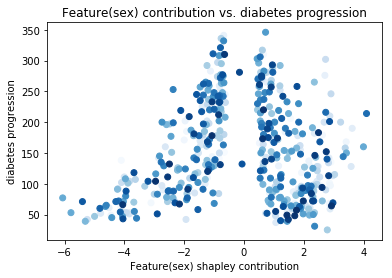

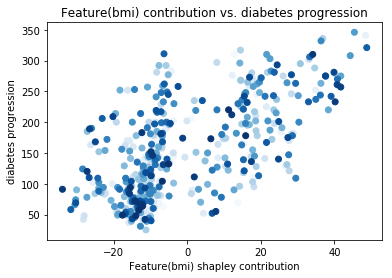

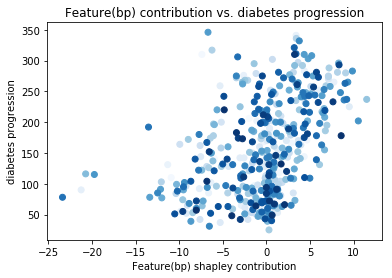

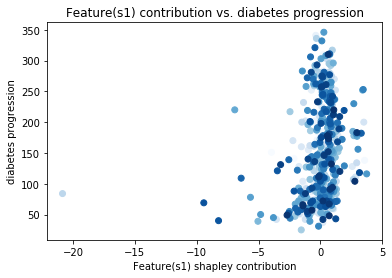

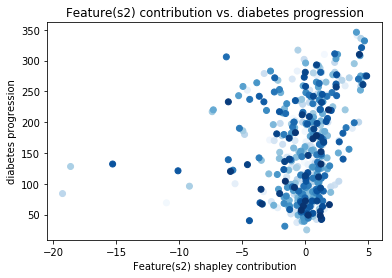

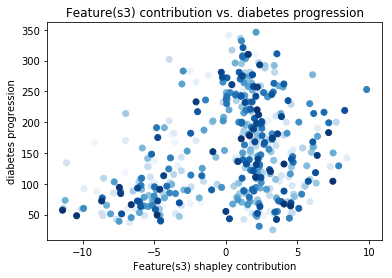

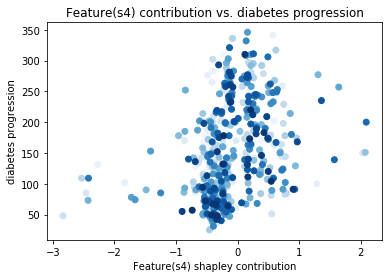

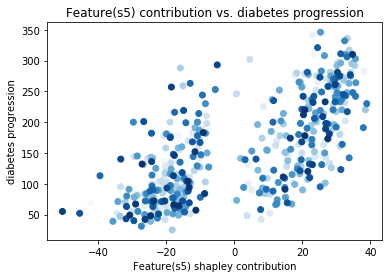

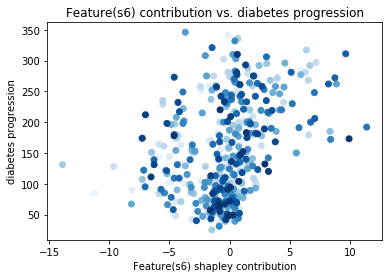

In [12]:
from Framework import plotHelper
plotHelper.plotAllFeatures(shap_dataframe)

In [13]:
#Start clustering
from Framework import cluster
from sklearn.cluster import KMeans
nClusters = 3
#Train KMeans, because the data is unsupervised(Regression data)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,shap_values)

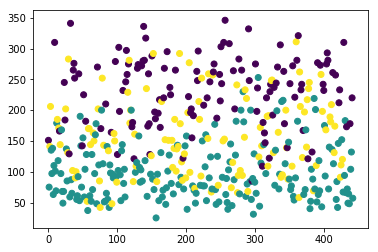

In [14]:
#Get the labels, concat into original data, and sor the labels for into cluster groups
shap_dataframe_labeled = pd.concat([shap_dataframe,pd.DataFrame(kmeans.labels_,columns =[ 'labels'])],axis = 1)
#shap_grouped = shap_dataframe_labeled.sort_values(['labels'])
X_labeled = pd.concat([X,shap_dataframe_labeled['labels']], axis = 1)
plt.scatter(np.linspace(0,442,442),y,c = X_labeled['labels'])

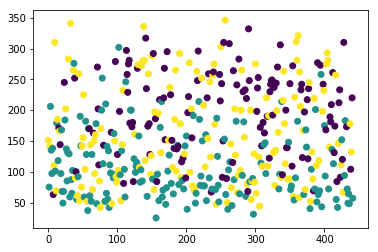

In [15]:
kmeans_original = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,X)
plt.scatter(np.arange(len(X)),y,c = kmeans_original.labels_)

In [16]:
#Split the clusters into a dictionary
data_dict = cluster.splitDataLabeled(nClusters,shap_dataframe,shap_dataframe_labeled['labels'])
data_dict_original = cluster.splitDataLabeled(nClusters,X,kmeans_original.labels_)

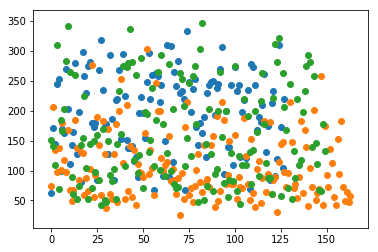

In [19]:
#Scatter the groups again...
#plt.scatter(np.linspace(-1,1,len(original_label_cluster2)),cluster2_predictions)
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster1'])),original_split['original_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster2'])),original_split['original_label_cluster2'].iloc[:,0])

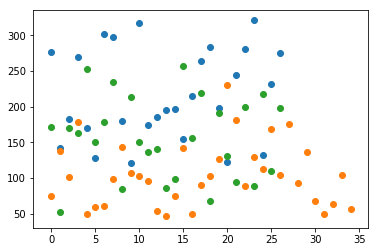

In [20]:
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster1'])),original_split_shapley['original_test_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster2'])),original_split_shapley['original_test_label_cluster2'].iloc[:,0])

In [41]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}

eval_results = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}

model_dict,eval_results = cluster.trainMultipleModels(xgboost.train,original_split,'XGBoost',params,**kwargs)
#small_model_1 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_2 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_3 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:80.9923	test-rmse:69.0553
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[64]	train-rmse:47.8458	test-rmse:55.1294

[0]	train-rmse:67.2156	test-rmse:72.8282
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[306]	train-rmse:31.3705	test-rmse:55.4213

[0]	train-rmse:82.7062	test-rmse:69.2464
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[21]	train-rmse:67.2054	test-rmse:66.0063



In [42]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shapley = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_shapley,eval_results_shapley = cluster.trainMultipleModels(xgboost.train,original_split_shapley,'XGBoost',params,**kwargs)
#small_model_shapley1 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_shapley2 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_shapley3 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:94.8148	test-rmse:88.2044
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[34]	train-rmse:47.7902	test-rmse:61.179

[0]	train-rmse:68.8987	test-rmse:63.1494
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[60]	train-rmse:41.9049	test-rmse:41.8774

[0]	train-rmse:64.3467	test-rmse:56.6126
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[28]	train-rmse:59.0028	test-rmse:54.2411



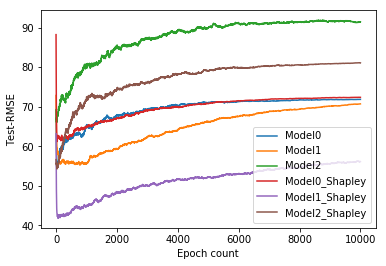

In [23]:
plt.plot(np.arange(len(eval_results['eval0']['test']['rmse'])),eval_results['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['test']['rmse'])),eval_results['eval2']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['test']['rmse'])),eval_results_shapley['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['test']['rmse'])),eval_results_shapley['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['test']['rmse'])),eval_results_shapley['eval2']['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

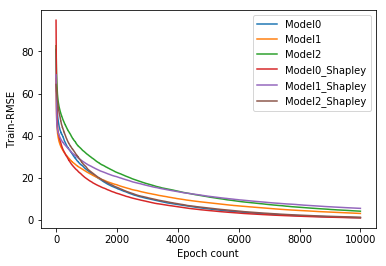

In [24]:
plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['train']['rmse'])),eval_results_shapley['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['train']['rmse'])),eval_results_shapley['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['train']['rmse'])),eval_results_shapley['eval2']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

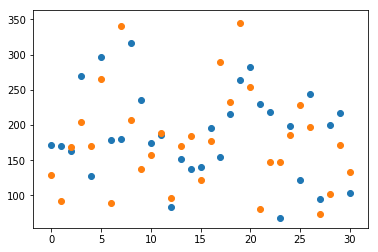

In [25]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),original_split['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),model_dict['model0'].predict(xgboost.DMatrix(original_split['original_test_cluster0'])))

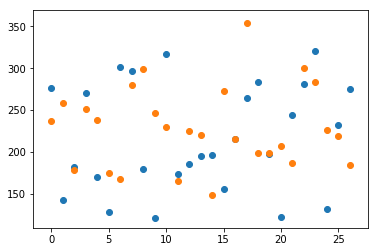

In [26]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),model_dict_shapley['model0'].predict(xgboost.DMatrix(original_split_shapley['original_test_cluster0'])))

In [54]:
#Train overall model
ev_result = {}
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse",
}
model = xgboost.train(params,xgboost.DMatrix(X_train, label=y_train),10000,evals = [(xgboost.DMatrix(X_train, label=y_train), "train"),(xgboost.DMatrix(X_test, label=y_test), "test")] ,verbose_eval = 1000,evals_result = ev_result,early_stopping_rounds = 200)
tot_result_big_model = min(ev_result['test']['rmse'])

[0]	train-rmse:77.0041	test-rmse:70.8919
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[74]	train-rmse:51.762	test-rmse:58.7024



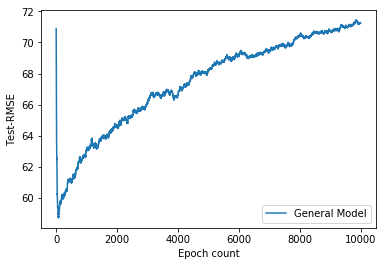

In [28]:
plt.plot(np.arange(len(ev_result['test']['rmse'])),ev_result['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['General Model'])

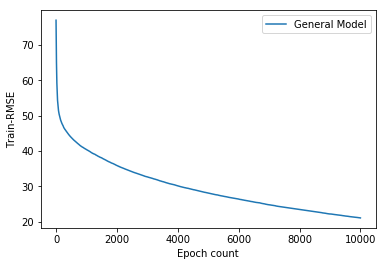

In [29]:
plt.plot(np.arange(len(ev_result['train']['rmse'])),ev_result['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['General Model'])

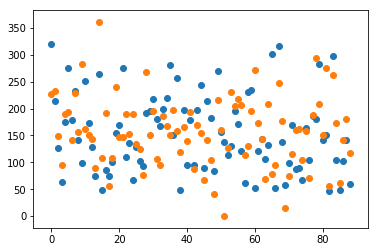

In [30]:
plt.scatter(np.arange(len(X_test)),y_test)
plt.scatter(np.arange(len(X_test)),model.predict(xgboost.DMatrix(X_test)))

In [61]:
#Evaluation of results
from Framework import metrics
sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split_shapley['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shapley['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap = metrics.ensembleRMSE(sizes,rmse_array)

Text(0.5, 1.0, 'Test-RMSE value vs. Method used')

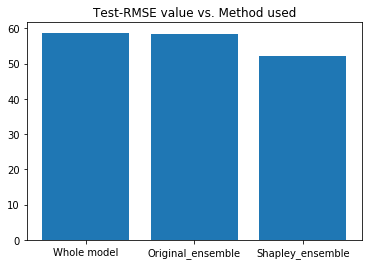

In [62]:
plt.bar(['Whole model','Original_ensemble','Shapley_ensemble'],[tot_result_big_model,tot_rmse_org,tot_rmse_shap])
plt.title('Test-RMSE value vs. Method used')

In [31]:
#Do PCA for dimensionality reduction
pca = PCA(n_components=2)
shap_values_pca = pca.fit_transform(shap_values)
print(pca.explained_variance_ratio_.sum())

0.92266536


Text(0, 0.5, 'Second principal component')

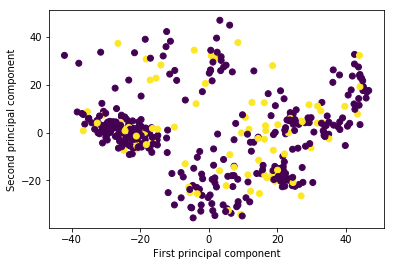

In [32]:
#PCA Clusters are quite seperate,could be used in clustering
label_colors = [ 0 if a == 'train' else 1 for a in X_instanced['instance']]
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = label_colors)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
#Add to labels to the scatter plot (Colors)
#How do we interpret this ?

In [33]:
kmeans_pca = cluster.clusterData(KMeans(n_clusters=2, random_state=0).fit,shap_values_pca)

Text(0, 0.5, 'Second principal component')

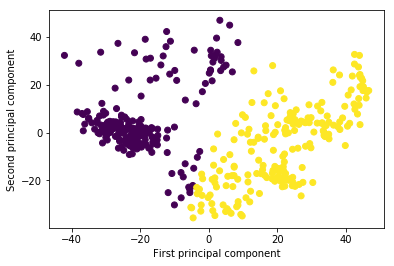

In [34]:
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = kmeans_pca.labels_)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [35]:
data_dict_shap_pca = cluster.splitDataLabeled(2,shap_values_pca,kmeans_pca.labels_)

In [36]:
original_shap_pca = cluster.convertOriginalData(data_dict_shap_pca,X_instanced,y_instanced)

In [37]:
original_shap_pca

{'original_data_cluster0':           age       sex       bmi        bp        s1        s2        s3  \
 0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
 1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
 2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
 3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
 4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
 5   -0.092695 -0.044642 -0.040696 -0.019442 -0.068991 -0.079288  0.041277   
 6   -0.045472  0.050680 -0.047163 -0.015999 -0.040096 -0.024800  0.000779   
 7    0.063504  0.050680 -0.001895  0.066630  0.090620  0.108914  0.022869   
 8    0.041708  0.050680  0.061696 -0.040099 -0.013953  0.006202 -0.028674   
 9   -0.070900 -0.044642  0.039062 -0.033214 -0.012577 -0.034508 -0.024993   
 10  -0.096328 -0.044642 -0.083808  0.008101 -0.103389 -0.090561 -0.013948   
 11   0.027178  0.050680  0.017506 -0.

In [39]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shap_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    #'early_stopping_rounds' : 2000
}
model_dict_shap_pca,eval_results_shap_pca = cluster.trainMultipleModels(xgboost.train,original_shap_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:74.7218	test-rmse:69.5467
[1000]	train-rmse:34.1171	test-rmse:64.0597
[2000]	train-rmse:27.6975	test-rmse:66.8997
[3000]	train-rmse:23.2644	test-rmse:67.9045
[4000]	train-rmse:19.9639	test-rmse:70.4592
[5000]	train-rmse:17.3237	test-rmse:71.3065
[6000]	train-rmse:15.1433	test-rmse:71.9128
[7000]	train-rmse:13.3335	test-rmse:72.6553
[8000]	train-rmse:11.715	test-rmse:73.1753
[9000]	train-rmse:10.2913	test-rmse:73.8052
[9999]	train-rmse:9.14963	test-rmse:74.287
[0]	train-rmse:74.3811	test-rmse:68.6993
[1000]	train-rmse:31.8311	test-rmse:68.5449
[2000]	train-rmse:25.2232	test-rmse:70.2417
[3000]	train-rmse:20.6075	test-rmse:71.4464
[4000]	train-rmse:17.2154	test-rmse:72.3431
[5000]	train-rmse:14.5112	test-rmse:72.1843
[6000]	train-rmse:12.3934	test-rmse:72.9721
[7000]	train-rmse:10.686	test-rmse:73.2138
[8000]	train-rmse:9.17737	test-rmse:73.6315
[9000]	train-rmse:7.9929	test-rmse:73.6394
[9999]	train-rmse:6.9746	test-rmse:73.9115


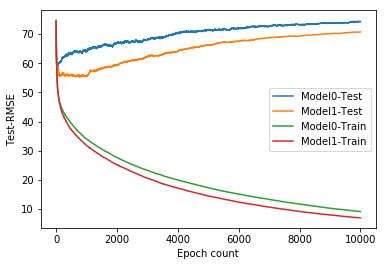

In [40]:
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['test']['rmse'])),eval_results_shap_pca['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['train']['rmse'])),eval_results_shap_pca['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['train']['rmse'])),eval_results_shap_pca['eval1']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0-Test','Model1-Test','Model0-Train','Model1-Train'])